<a href="https://colab.research.google.com/github/hwarang97/hukppenhiem/blob/main/DACON_pytorch_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link

link : https://dacon.io/codeshare/4478

# Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms

# Hyper-parameter

In [2]:
shp_original_img=(100,100)
lr = 0.8

# Loading Images

In [3]:
original_image = PIL.Image.open('./Eiffel.jpg') # 아무 이미지 받아서 사용하면 됌
# original_image.show()

tf = transforms.ToTensor()
original_img = tf(original_image)
original_img_re = transforms.functional.resize(original_img, shp_original_img)
print(type(original_img_re))
print(original_img_re.shape)

<class 'torch.Tensor'>
torch.Size([3, 100, 100])


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<PIL.Image.Image image mode=RGB size=100x100 at 0x7F93F077E8B0>


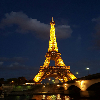

In [4]:
# 제대로 사이즈 조정이 되었는지 확인
retf = transforms.ToPILImage()
original_image_re = retf(original_img_re)
print(original_image_re)
original_image_re.show()

# Local Functions

In [5]:
# 이미지를 오염시키는 함수
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

# 두 이미지의 차이를 측정하는 함수
def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image) 

# Get Weired Image 

In [6]:
# 오염된 이미지 생성

'''
weird_function 을 사용하기 위해서는 이미지를 1D tensor로 바꾸어줘서 적용해야하는듯
채널 또한 1개로 바꿔줘야한다.
'''

original_img_tf=original_img_re.view(3,-1)[0] # (3,10000) 에서 하나를 가져감
# print(original_img_tf)
# print(original_img_tf.shape)

# 오염된 이미지 텐서 생성
weird_img_tf = weird_function(original_img_tf)
# print(weird_img_tf)
# print(weird_img.shape)

## <복습. 왜 reshape가 아닌 view>

reshape : 기존 텐서를 변형함(재활용)   
view : 기존 데이터를 두고 새로운 텐서를 생성 후 반환(새텐서)   

여기서는 둘 중 아무거나 사용해도 상관없지만, 새로 배운 view를 쓰고 싶어서 적용해봄

In [ ]:
# 무작위 텐서 생성
random_tensor = torch.randn(10000, dtype=torch.float) # -> weird_function 에 넣기 위해서 1D tensor 꼴로 바꿈

In [ ]:
import torch

# x= torch.tensor(2.)
x= torch.tensor(2., requires_grad=True)

for _ in range(1):

    y = x**2
    z = 3*(y**4)
    z.backward()
    grad = x.grad
    print(grad)

<class 'torch.Tensor'>
None


In [4]:
# 경사하강법

loss_history = [] # loss 변화를 보기 위해서 설정한 변수

for i in range(20000):
    random_tensor.requires_grad_(True) # computational gragh를 그리기 시작 (random_tensor는 leaf node)
    hypothesis = weird_function(random_tensor)
    loss = distance_loss(weird_img_tf, hypothesis)

    loss_history += [loss.item()]

    # grad 초기화
    # random_tensor.grad = None # 딱히 결과적으로 차이는 없어보이는데

    loss.backward() # 미분 실행. backward(), autograd.grad()를 실행하면 그래프 중간값이 사라진다고함
    grad = random_tensor.grad

    # 직접 경사하강법을 구현해보기 위해 grad를 안씀
    with torch.no_grad(): # lear node를 유지하기 위해서 + 메모리 낭비(grad_fn)을 없애기 위해
        random_tensor = random_tensor-lr*random_tensor # 여기서 random_tensor가 새롭게 초기화가 되면서 grad값이 None으로 설정

    if i%1000 == 0:
        # print(f'loss at {i} : {loss.item()}')
        # print(f'grad at {i} : {torch.linalg.vector_norm(random_tensor.grad)}') # 위에서 random_tensor 값을 새롭게 초기화했으므로 grad 값은 None으로 되어있음
        # print(f'grad at {i} : {torch.linalg.vector_norm(grad)}')

IndentationError: ignored

In [ ]:
a = torch.tensor([[1., 2., 3., 4.],
                 [-1.,-2.,-3.,-4]])

print(torch.linalg.matrix_norm(a))


b = torch.tensor([[1.,2.,3.,4.,5.,6.],
                  [-1.,-2.,-3.,-4.,-5.,-6.]])

print(torch.linalg.matrix_norm(b))

tensor(7.7460)
tensor(13.4907)


## <추가학습. leaf node>

lear node : If our Tensor is a leaf node (initialised by the user), then the grad_fn is also None. (사용자에 의해 설정된 값을 갖는 텐서, 그러면 grad_fn이 None으로 설정된다)



관련 링크 : https://bnikolic.co.uk/blog/pytorch/python/2021/03/15/pytorch-leaf.html 

https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/2

with torch.no_grad()를 해제하니까 

1번은 실행되지만, 2번째 실행될 때 문제가 발생

- 원인은 random\_tensor가 requires\_grad=True인 상태로 계산이 되면 자기 자신으로 연산이 들어가 더 이상 leaf node가 아니게 된다. 따라서 loss.backward() 부분에서 leaf node가 사라지게 되어 미분이 진행되지 않는것으로 보인다.

<경고문1>

'UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.) grad = random_tensor.grad'

  경고문이 뜨면서 문제 발생

  <경고문 아래 상세내용>

  Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

## <추가학습> grad를 초기화하지 않고 진행했으므로, 기울기값이 계속 커져서 loss 그래프가 이상하게 변하지 않았을까 확인해보자

- random_tensor = random_tensor-lr*random_tensor # 여기서 random_tensor가 새롭게 초기화가 되면서 grad값이 None으로 설정이 되어 값이 누적이 안되는것이다!!!

<function matplotlib.pyplot.show(close=None, block=None)>

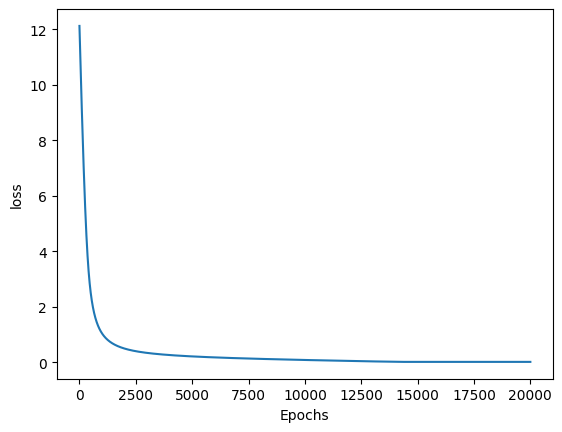

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,20000+1), loss_history)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show

## <복습. tensor 값 접근>
Tensor.item을 이용하면 됨


In [ ]:
a = torch.tensor([1.])
print(a)

# 실제로 잘 복원했는지 확인

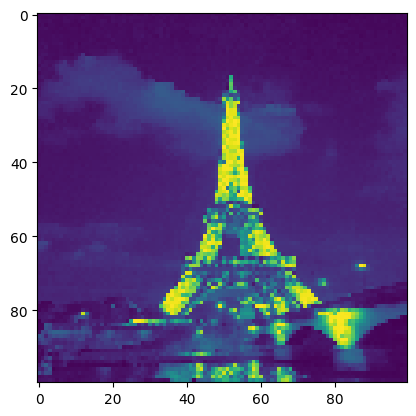

In [ ]:
# 방법1 (pyplot을 이용). 장점은 나름 컬러화
plt.imshow(random_tensor.view(100,100).data)

<PIL.Image.Image image mode=L size=100x100 at 0x7FD96F99B400>


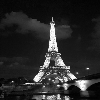

In [ ]:
# 방법2
# print(random_tensor.shape)
retf = transforms.ToPILImage()
random_tensor_image = retf(random_tensor.view(100,100)) # 행렬꼴로 바꾸어는 주어야 함
print(random_tensor_image)
random_tensor_image.show()

## 심화학습 (인공신경망으로 구현해보기)

구현하는데 RAM 문제가 떠서 일단 중단

In [9]:
#import torch
from torch import nn
from torch import optim

class mynn(nn.Module):
    def __init__(self):
        super().__init__()

        self.Linear = nn.Sequential(
            nn.Linear(10000, 20000),
            nn.ReLU(),
            nn.Linear(20000, 40000),
            nn.ReLU(),
            nn.Linear(40000, 20000),
            nn.ReLU(),
            nn.Linear(20000, 10000),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.Linear(x)
        return x

model = mynn()
x = torch.randn(10000)
y = model(x)

In [10]:
# hyper parameters
LR = 0.8
EPOCH = 2000

In [11]:
hypothesis = weird_function(x)
loss = distance_loss(weird_img_tf, hypothesis)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_history = []
model = mynn()
x = torch.randn(10000)

In [12]:
model.train()

for ep in range(1, EPOCH+1):
    y_hat = model(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history += [loss.item()]
    print(f"Epoch: {ep+1}, train loss: {round(loss.item(),3)}")
    print("-"*20)

RuntimeError: ignored